# Evolutionary Algorithms in Brain Microstructure Modeling

## Magnetic Resonance Imaging (MRI)

MRI allows to acquire images of living tissue, e.g. human brain. Typically, every image voxel represents a cubic volume of dimensions from 1x1x1 [mm] to 2x2x2 [mm], depending on MRI scanner parameters. Such resolution allows for instance to delineate grey and white matter tissue, as illustrated below.
<br /><br />

<div align="center">
   <img src="hcp_sample_t1.png" width="80%" />
   sample T1-weighted image,
   <em>source: Human Connectome Project</em>
</div>
<br />

<strong>Grey matter</strong> comprises of densely packed neuronal bodies, whereas <strong>white matter</strong> is formed of axons and dendrites aligned in fiber bundles. The bundles play a role of neuronal connections between distant grey matter areas, resembling a network of "highways" inside the brain.
<br /><br />

<div align="center">
   <img src="white_matter_tracts.png" width="80%" />
   sample white matter tracts,
   <em>source: https://radiologykey.com/white-matter-tracts/</em>
</div>

<br />

## Diffusion Weighted Imaging (DWI)

DWI is an imaging technique that captures mean displacement of water molecules in specified 3D directions, e.g. left-right, front-rear, top-bottom:
<br /><br />

<div align="center">
    <img src="hcp_sample_dwi.png" width="80%" />
    sample DWI-weighted images,
    <em>source: Human Connectome Project</em>    
</div>
<br />

Areas of <strong>high diffusivity</strong> are represented with darkest shades on diffusion weighted images. In the example above, the diffusivity in X direction (i.e. left-right) dominates the other two directions inside the highlighed region.
<br /><br />

We know (from physics and neuroanatomy) that water inside white matter "prefers" to diffuse along fibers rather than perpendicularly. With this in mind, DWI offers us an opportunity to capture anatomical features hidden below nominal imaging resolution. In particular, post processing of diffusion weighted images gives us spacial orientations of fibers inside each voxel containing white matter.
<br /><br />

<div align="center">
    <img src="ball_and_stick_fitted.png" width="60%" />
    orientations of fiber bundles in a sample region of white matter,
    <em>source: Human Connectome Project</em>    
</div>
<br />

Further postprocessing allows to obtain <strong>tractogram</strong> which is a color-coded map of neuronal connections inside the brain. Currently, tractograms are used both in research (e.g. neuroscience) and clinical practice (e.g. pre-surgical planning).
<br /><br />

<div align="center">
    <img src="tractogram.jpg" width="80%" />
    sample tractogram,
    <em>source: http://mcgovern.mit.edu/news/images/brain-scan-cover-image-summer-2013/</em>
</div>

<br />

## Microstructure modeling

In practice, diffusion signal is acquired from many directions and with various imaging settings. Protocols used by clinicians comprise of at least 32 images, whereas data sets processed by researchers contain even hundreds of diffusion weighted images per subject. Generally, the more images we have, the more exactly we can estimate microstructure features inside voxels. 
<br /><br />

<div align="center">
    <img src="dwi_imaging_directions.png" width="40%" />
    sample map of imaging directions,
    <em>source: http://www.emmanuelcaruyer.com/q-space-sampling.php</em>    
</div>
<br />

In order to process diffusion weighted images, we need a mathematical model that would fit the measured signal. One of the simplest models of this type is called <strong>Ball and Stick</strong>. The <em>ball</em> part of this model represents diffusion of extra-cellular water (that is not interesting for us now), whereas the <em>stick</em> part represents intra-cellular diffusion of water trapped inside axons.
<br /><br />

<div align="center">
    <img src="ball_and_stick_illustration.png" width="80%" />
    sample ball and stick configurations inside voxels
</div>
<br />

### Ball and Stick - formal definition

Let $M$ > 0 be the number of diffusion weighted images. For all $k = 1, ..., M$, the signal is modelled as
<br /><br />

<div align="center">
$S_k = S_0 \left[ f_{ball} \cdot \exp \left(-b_k \lambda_{iso} (\mathbf{g}_k^T \mathbf{v})^2 \right) + f_{stick} \cdot \exp(-b_k \lambda_{\parallel}) \right]$,
</div>

where:

- $f_{ball}, f_{stick} \in (0, 1)$ are weighing parameters of ball and stick fractions respectively, 
- $\lambda_{iso} \in \mathbb{R}$ is an isotropic diffusivity (inside the ball),
- $\lambda_{parallel} \in \mathbb{R}$ is a parallel diffusivity (inside the stick),
- $v = [\sin\mu_1 \cos\mu_2, \sin\mu_1 \sin\mu_2, \cos\mu_1]^T$ is a stick direction with $\mu = (\mu_1, \mu_2) \in [0, \pi] \times [0, 2\pi)$.
- $S_0$ is the signal acquired without diffusion sensitizing gradient (given),
- $\mathbf{g_k} \in \mathbb{R}_+^3$ and $b_k \in \mathbb{R}_+$ are the acquisition parameters (given).


## Simple example

The source code of this example requires <strong>dmipy</strong> module https://github.com/AthenaEPI/dmipy with its dependencies:
- numpy >= 1.13
- scipy
- dipy
- nibabel
- cvxpy
- fury


In [2]:
%%time

import nibabel as nib
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
%matplotlib inline

import dmipy.data.saved_acquisition_schemes as saved_acquisition_schemes

from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.core.fitted_modeling_framework import FittedMultiCompartmentModel

from dipy.viz import window, actor

import tqdm

import warnings
warnings.filterwarnings("ignore")

CPU times: user 5.22 ms, sys: 3.11 ms, total: 8.33 ms
Wall time: 13.9 ms


In [3]:
import numba
import pathos

First, we load a sample slice of DWI data from the Human Connectome Project repository: https://www.humanconnectome.org/

In [4]:
data_hcp = nib.load('wu_minn_hcp_coronal_slice.nii.gz').get_data()
scheme_hcp = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

We define a rectangular Region Of Interest (ROI):

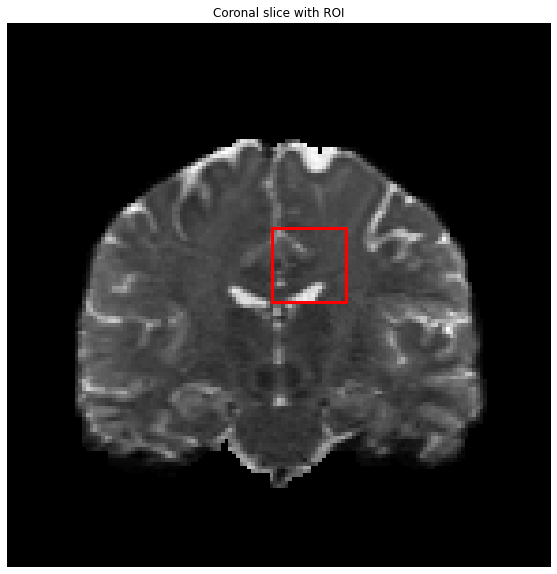

In [5]:
roi = {'x': 70, 'y': 70, 'width': 20, 'height': 20}
data_hcp_roi = data_hcp[
    roi['x'] : roi['x'] + roi['width'], :, roi['y'] : roi['y'] + roi['height']
]

fig, ax = plt.subplots(figsize=[10, 10])
ax.imshow(data_hcp[:, 0, :, 0].T, origin='lower', cmap='gray', interpolation='nearest')

rect = patches.Rectangle(
    (roi['x'], roi['y']), roi['width'], roi['height'], 
    linewidth = 3, edgecolor = 'r', facecolor = 'none'
)
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('Coronal slice with ROI');

Next, we create an instance of the Ball and Stick diffusion model.

In [6]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

Our model requires fitting the following five parameters for every image voxel:
- G1Ball_1_lambda_iso – extra-cellular diffusivity coefficient (real value * $10^{-9}$),
- C1Stick_1_mu – direction of a stick (2-dimensional real vector of sphere coordinates),
- C1Stick_1_lambda_par – intra-cellular diffusivity coefficient (real value * $10^{-9}$),
- partial_volume_0 – weight of the intra-cellular diffusion fraction (real value),
- partial_volume_1 – weight of the extra-cellular diffusion fraction (real value).

The ranges of parameters are given below:

In [7]:
bas_model.parameter_ranges

OrderedDict([('C1Stick_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('C1Stick_1_lambda_par', (0.1, 3)),
             ('G1Ball_1_lambda_iso', (0.1, 3)),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

### Dummy solution

Let's try setting random parameters to our Ball and Stick model.

In [8]:
def set_parameters(our_voxel_bas_model, scheme_hcp, voxel_signal):
    params = []

    # estimate S0
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    # G1Ball_1_lambda_iso
    param_range = our_voxel_bas_model.parameter_ranges['G1Ball_1_lambda_iso']
    lambda_iso = np.random.uniform(param_range[0], param_range[1]) * 1e-09

    # C1Stick_1_mu
    param_ranges = our_voxel_bas_model.parameter_ranges['C1Stick_1_mu']
    mu_1 = np.random.uniform(param_ranges[0][0], param_ranges[0][1])
    mu_2 = np.random.uniform(param_ranges[1][0], param_ranges[1][1])
    
    # C1Stick_1_lambda_par
    param_range = our_voxel_bas_model.parameter_ranges['C1Stick_1_lambda_par']
    lambda_parallel = np.random.uniform(param_range[0], param_range[1]) * 1e-09
    
    # partial_volume_0
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_0']
    f_stick = np.random.uniform(param_range[0], param_range[1])
    
    # partial_volume_1
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_1']
    f_ball = np.random.uniform(param_range[0], param_range[1])
            
    return FittedMultiCompartmentModel(
        our_voxel_bas_model, np.array(S0), np.array([True]), 
        np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    our_bas_model[x] = {}
    for y in range(roi['height']):
        
        voxel_signal = data_hcp_roi[x, 0, y, :]
        our_bas_model[x][y] = set_parameters(bas_model, scheme_hcp, voxel_signal)
        
        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)
          
print("Fitting accuracy:")        
print("MSE +/- STD = %f +/- %f" % (np.mean(voxel_mse), np.std(voxel_mse)))

Fitting accuracy:
MSE +/- STD = 0.096293 +/- 0.086481


The mean squared errors are relatively high and dispersed. The orientations of fiber bundles (red lines) and volumes of intra-cellular diffusion (grayscale shades) look random on a visualization below.

our randomized model:


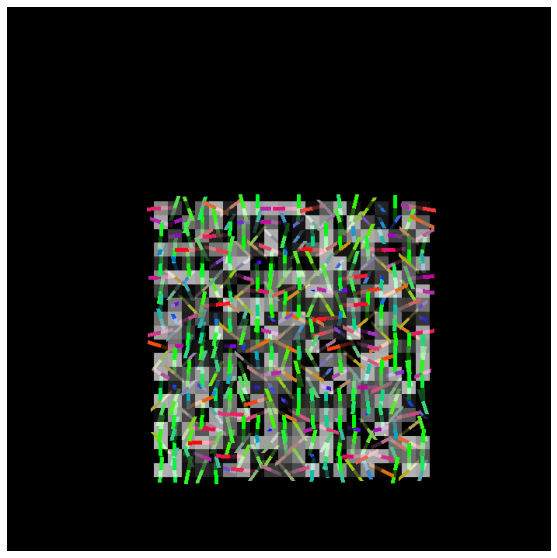

In [9]:
def visualize_result(bas_models_fit):

    affine = np.eye(4)
    affine[0,3] = -10
    affine[1,3] = -10

    volume = np.zeros([roi['width'], roi['height'], 1])
    peak_dirs = np.zeros([roi['width'], roi['height'], 1, 1, 3])

    for x in range(roi['width']):
        for y in range(roi['height']):
            volume[x, y, 0] = bas_models_fit[x][y].fitted_parameters['partial_volume_0']
            peak_cart = np.squeeze(bas_models_fit[x][y].peaks_cartesian())
            peak_dirs[x, y, 0] = [peak_cart[0], peak_cart[2], -peak_cart[1]]

    ren = window.ren()
    ren.add(actor.slicer(volume, interpolation='nearest', affine=affine, opacity=0.7))
    ren.add(actor.peak_slicer(peak_dirs, None, affine=affine, linewidth=5, colors=None))   

    window.record(ren, size=[700, 700], out_path='dipy.png')
    
    img = mpimg.imread('dipy.png')
    plt.figure(figsize=[10, 10])
    plt.imshow(img) #[100:-97, 100:-85])
    plt.axis('off');
    
print("our randomized model:")
visualize_result(our_bas_model)

### State-of-the-art solution

For comparison, let's try now a state-of-the-art solution.

In [25]:
%%time
reference_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    reference_bas_model[x] = {}
    for y in range(roi['height']):
        
        voxel_signal = data_hcp_roi[x, 0, y, :]
        reference_bas_model[x][y] = bas_model.fit(scheme_hcp, voxel_signal)
        
        voxel_mse[x][y] = reference_bas_model[x][y].mean_squared_error(voxel_signal)
        
print("Fitting accuracy:")        
print("MSE +/- STD = %f +/- %f" % (np.mean(voxel_mse), np.std(voxel_mse)))

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.3140828609466553 seconds
Fitting of 1 voxels complete in 2.898350715637207 seconds.
Average of 2.898350715637207 seconds per voxel.
Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.29415416717529297 seconds
Fitting of 1 voxels complete in 2.2313249111175537 seconds.
Average of 2.2313249111175537 seconds per voxel.
Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.27869367599487305 seconds
Fitting of 1 voxels complete in 2.177934169769287 seconds.
Average of 2.177934169769287 seconds per voxel.
Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.277789831161499 seconds
Fitting of 1 voxels complete in 2.1657423973083496 seconds.
Average of 2.1657423973083496 seconds per voxel.
Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.2782931327819824 seconds
Fitting of 1 voxels complete in 2.1238839626312256 seconds.
Average of 2

The MSEs and STDs are much lower than before. Also, the visualization of fiber bundles looks more realistic.

state-of-the-art model:


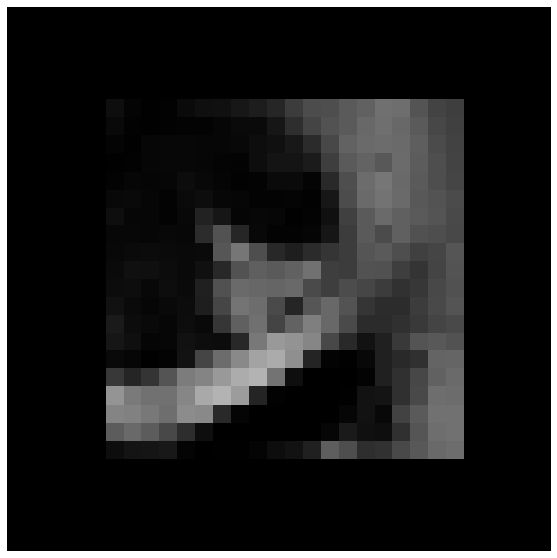

In [26]:
print("state-of-the-art model:")
visualize_result(reference_bas_model)

### Assignment

Use any optimization engine that you know (e.g. genetic algorithm) and compare your results with the state-of-the-art solution. 
- Can your solution produce more exact fitting? 
- Are the MSEs less dispersed?
- Does it work faster than the reference method?

## PLAN
- ES gdzie jeśli poza dziedziną to losujemy z dziedziny

In [13]:
def domain_dict_to_array(d):
    domains_dict = d
    domains_list = np.array(list(domains_dict.values()))
    domains_array = np.array(domains_list[0][0])
    domains_array = np.vstack((domains_array, domains_list[0][1]))
    domains_array = np.vstack((domains_array, domains_list[1]))
    domains_array = np.vstack((domains_array, domains_list[2]))
    domains_array = np.vstack((domains_array, domains_list[3]))
    domains_array = np.vstack((domains_array, domains_list[4]))
    return domains_array

In [14]:
bas_model.parameter_ranges

OrderedDict([('C1Stick_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('C1Stick_1_lambda_par', (0.1, 3)),
             ('G1Ball_1_lambda_iso', (0.1, 3)),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

In [15]:
domain_dict_to_array(bas_model.parameter_ranges)

array([[0.0, 3.141592653589793],
       [-3.141592653589793, 3.141592653589793],
       [0.1, 3],
       [0.1, 3],
       [0.01, 0.99],
       [0.01, 0.99]], dtype=object)

In [16]:
# 6 values per voxel so x * y * 6 in chromosome

In [15]:
x_me, y_me = 20, 20
chromosome_example = np.zeros((x_me, y_me, 6))
print(chromosome_example.shape)

(20, 20, 6)


In [16]:
def array_to_dict(a):
    # TODO
    # do poprawy bo C1Stick_1_mu ma tupla a nie jedną wartość
    d = bas_model.parameter_ranges
    fd = {}
    fd['C1Stick_1_mu'] = a[0]
    fd['C1Stick_1_lambda_par'] = a[1]
    fd['G1Ball_1_lambda_iso'] = a[1]
    fd['partial_volume_0'] = a[1]
    fd['partial_volume_1'] = a[1]
    return fd

In [15]:
chro1 = chromosome_example[0][0]
array_to_dict(chro1)

{'C1Stick_1_mu': 0.0,
 'C1Stick_1_lambda_par': 0.0,
 'G1Ball_1_lambda_iso': 0.0,
 'partial_volume_0': 0.0,
 'partial_volume_1': 0.0}

In [16]:
domain_dict_to_array(bas_model.parameter_ranges)

array([[0.0, 3.141592653589793],
       [-3.141592653589793, 3.141592653589793],
       [0.1, 3],
       [0.1, 3],
       [0.01, 0.99],
       [0.01, 0.99]], dtype=object)

In [26]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, R=None):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 1e10

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    
    def mut3(og):
        S = np.random.uniform(0,sigma, size=(chromosome_length, chromosome_length))
        S = np.dot(S,S.T)
        return og + np.dot(np.random.randn(number_of_offspring, chromosome_length), np.linalg.cholesky(S).T)
    
    def in_domain(chrom, R):
        for p in range(len(chrom)):
            R_ind = p % 6
            if not R[R_ind][0] < chrom[p] < R[R_ind][1]:
                chrom[p] = np.random.uniform(R[R_ind][0],R[R_ind][1])
        return chrom
    
    def initial_population(population_size, R):
        current_population_solutions = np.zeros((population_size, chromosome_length))
        for pop in range(population_size):
            for p in range(chromosome_length):
                R_ind = p % 6
                current_population_solutions[pop][p] = np.random.uniform(R[R_ind][0],R[R_ind][1])
        return current_population_solutions
            
    
    mutation_f = mut3

    # generating an initial population
    current_population_solutions = initial_population(population_size, R)

    # evaluating the objective function on the current population
    current_population_objective_values = np.zeros(population_size)
    for i, guy in enumerate(current_population_solutions):
            current_population_objective_values[i] = objective_function(guy)

    for t in tqdm.tqdm(range(number_of_iterations)):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_solutions = mutation_f(children_population_solutions)
        
        # check if in domain
        for chrom in children_population_solutions:
            chrom = in_domain(chrom, R)                
        
        # evaluating the objective function on the children population
        children_population_objective_values = np.zeros(len(children_population_solutions))
        for i, child in enumerate(children_population_solutions):
            children_population_objective_values[i] = objective_function(child)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])

        I = np.argsort(-current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population_solutions[0]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        
        if log_frequency != -1 and np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 0].min(), log_objective_values[t, 2]))
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions

In [27]:
def plot_values(history_objective_values): 
    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0], 'g-',label='min')
    plt.plot(history_objective_values[:, 1], 'r-',label='max')
    plt.plot(history_objective_values[:, 2], 'b-',label='avg')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

In [28]:
def set_random_parameters(our_voxel_bas_model, scheme_hcp, voxel_signal):
    params = []

    # estimate S0
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    # G1Ball_1_lambda_iso
    param_range = our_voxel_bas_model.parameter_ranges['G1Ball_1_lambda_iso']
    lambda_iso = np.random.uniform(param_range[0], param_range[1]) * 1e-09

    # C1Stick_1_mu
    param_ranges = our_voxel_bas_model.parameter_ranges['C1Stick_1_mu']
    mu_1 = np.random.uniform(param_ranges[0][0], param_ranges[0][1])
    mu_2 = np.random.uniform(param_ranges[1][0], param_ranges[1][1])
    
    # C1Stick_1_lambda_par
    param_range = our_voxel_bas_model.parameter_ranges['C1Stick_1_lambda_par']
    lambda_parallel = np.random.uniform(param_range[0], param_range[1]) * 1e-09
    
    # partial_volume_0
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_0']
    f_stick = np.random.uniform(param_range[0], param_range[1])
    
    # partial_volume_1
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_1']
    f_ball = np.random.uniform(param_range[0], param_range[1])
            
    return FittedMultiCompartmentModel(
        our_voxel_bas_model, np.array(S0), np.array([True]), 
        np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )


def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )

def objective_function(ch, bas_model, scheme_hcp, voxel_signal):
    new_chroms = ch.reshape((roi['width'], roi['height'], 6))
    
    our_bas_model = {}
    voxel_mse = np.zeros([roi['width'], roi['height']])

    for x in range(roi['width']):
        our_bas_model[x] = {}
        for y in range(roi['height']):

            voxel_signal = data_hcp_roi[x, 0, y, :]
            our_bas_model[x][y] = set_params_from_chrom(new_chroms[x][y], bas_model, scheme_hcp, voxel_signal)

            voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

    return np.mean(voxel_mse)

  3%|██▊                                                                                | 1/30 [00:23<11:31, 23.86s/it]

Iteration 0000 : best score = 0.08847489, mean score = 0.09917853.
0.08847489207101812


 20%|████████████████▌                                                                  | 6/30 [02:21<09:22, 23.44s/it]

Iteration 0005 : best score = 0.08847489, mean score = 0.09549676.
0.08847489207101812


 37%|██████████████████████████████                                                    | 11/30 [04:16<07:21, 23.21s/it]

Iteration 0010 : best score = 0.08693082, mean score = 0.09430349.
0.08693081912056977


 53%|███████████████████████████████████████████▋                                      | 16/30 [06:14<05:28, 23.45s/it]

Iteration 0015 : best score = 0.08693082, mean score = 0.09342002.
0.08693081912056977


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [08:14<03:36, 24.05s/it]

Iteration 0020 : best score = 0.08693082, mean score = 0.09311343.
0.08693081912056977


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [10:12<01:34, 23.64s/it]

Iteration 0025 : best score = 0.08693082, mean score = 0.09272443.
0.08693081912056977


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [11:46<00:00, 23.55s/it]


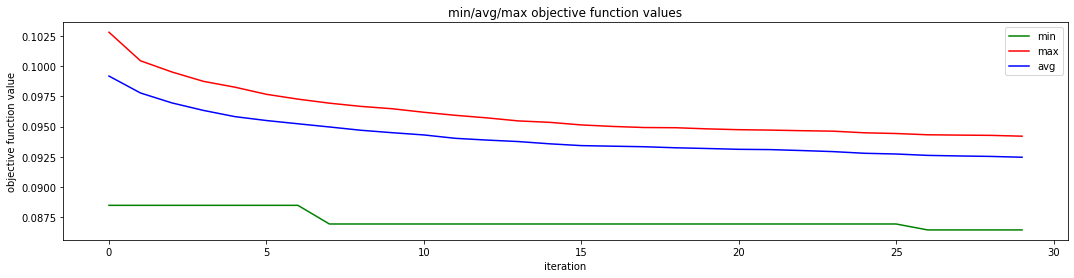

In [29]:
d = 6 * 20 * 20
N = 200
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome = es(
    lambda ch: objective_function(ch, bas_model, scheme_hcp, voxel_signal), d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 5, R=domain_dict_to_array(bas_model.parameter_ranges))

plot_values(history_objective_values)

  1%|▊                                                                                 | 1/100 [00:12<20:05, 12.18s/it]

Iteration 0000 : best score = 0.08922344, mean score = 0.09922103.
0.08922344368479013


  6%|████▉                                                                             | 6/100 [01:14<19:12, 12.27s/it]

Iteration 0005 : best score = 0.08782410, mean score = 0.09500234.
0.08782409984433656


 11%|████████▉                                                                        | 11/100 [02:16<18:35, 12.54s/it]

Iteration 0010 : best score = 0.08782410, mean score = 0.09396779.
0.08782409984433656


 16%|████████████▉                                                                    | 16/100 [03:18<17:16, 12.34s/it]

Iteration 0015 : best score = 0.08782410, mean score = 0.09353208.
0.08782409984433656


 21%|█████████████████                                                                | 21/100 [04:18<15:58, 12.13s/it]

Iteration 0020 : best score = 0.08782410, mean score = 0.09300748.
0.08782409984433656


 26%|█████████████████████                                                            | 26/100 [05:18<14:48, 12.01s/it]

Iteration 0025 : best score = 0.08782410, mean score = 0.09267169.
0.08782409984433656


 31%|█████████████████████████                                                        | 31/100 [06:19<13:55, 12.11s/it]

Iteration 0030 : best score = 0.08782410, mean score = 0.09212589.
0.08782409984433656


 36%|█████████████████████████████▏                                                   | 36/100 [07:18<12:41, 11.90s/it]

Iteration 0035 : best score = 0.08782410, mean score = 0.09190357.
0.08782409984433656


 41%|█████████████████████████████████▏                                               | 41/100 [08:19<11:48, 12.00s/it]

Iteration 0040 : best score = 0.08774228, mean score = 0.09159601.
0.0877422784779257


 46%|█████████████████████████████████████▎                                           | 46/100 [09:18<10:49, 12.03s/it]

Iteration 0045 : best score = 0.08774228, mean score = 0.09142785.
0.0877422784779257


 51%|█████████████████████████████████████████▎                                       | 51/100 [10:20<09:51, 12.06s/it]

Iteration 0050 : best score = 0.08774228, mean score = 0.09133533.
0.0877422784779257


 56%|█████████████████████████████████████████████▎                                   | 56/100 [11:19<08:45, 11.95s/it]

Iteration 0055 : best score = 0.08774228, mean score = 0.09121730.
0.0877422784779257


 61%|█████████████████████████████████████████████████▍                               | 61/100 [12:18<07:38, 11.76s/it]

Iteration 0060 : best score = 0.08774228, mean score = 0.09113558.
0.0877422784779257


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [13:16<06:36, 11.68s/it]

Iteration 0065 : best score = 0.08774228, mean score = 0.09106498.
0.0877422784779257


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [14:15<05:40, 11.74s/it]

Iteration 0070 : best score = 0.08774228, mean score = 0.09101774.
0.0877422784779257


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [15:13<04:40, 11.68s/it]

Iteration 0075 : best score = 0.08774228, mean score = 0.09094123.
0.0877422784779257


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [16:12<03:41, 11.65s/it]

Iteration 0080 : best score = 0.08774228, mean score = 0.09089479.
0.0877422784779257


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [17:11<02:44, 11.75s/it]

Iteration 0085 : best score = 0.08774228, mean score = 0.09082207.
0.0877422784779257


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [18:09<01:45, 11.71s/it]

Iteration 0090 : best score = 0.08774228, mean score = 0.09079353.
0.0877422784779257


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [19:07<00:46, 11.63s/it]

Iteration 0095 : best score = 0.08774228, mean score = 0.09077811.
0.0877422784779257


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [19:53<00:00, 11.93s/it]


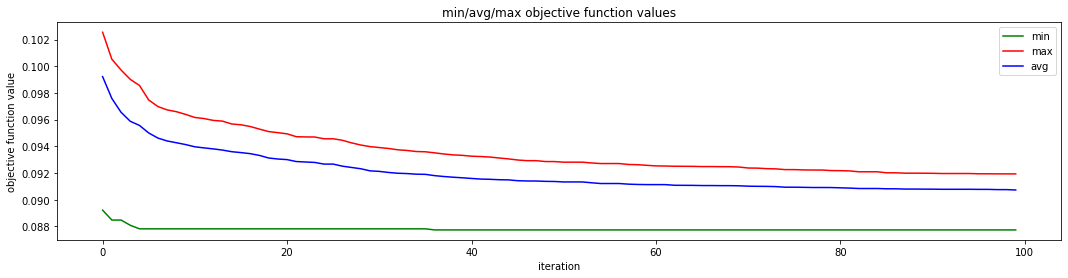

In [30]:
d = 6 * 20 * 20
N = 100
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome = es(
    lambda ch: objective_function(ch, bas_model, scheme_hcp, voxel_signal), d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 5, R=domain_dict_to_array(bas_model.parameter_ranges))

plot_values(history_objective_values)

In [31]:
def objective_function_and_model(ch, bas_model, scheme_hcp, voxel_signal):
    new_chroms = ch.reshape((roi['width'], roi['height'], 6))
    
    our_bas_model = {}
    voxel_mse = np.zeros([roi['width'], roi['height']])

    for x in range(roi['width']):
        our_bas_model[x] = {}
        for y in range(roi['height']):

            voxel_signal = data_hcp_roi[x, 0, y, :]
            our_bas_model[x][y] = set_params_from_chrom(new_chroms[x][y], bas_model, scheme_hcp, voxel_signal)

            voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

    return np.mean(voxel_mse), our_bas_model

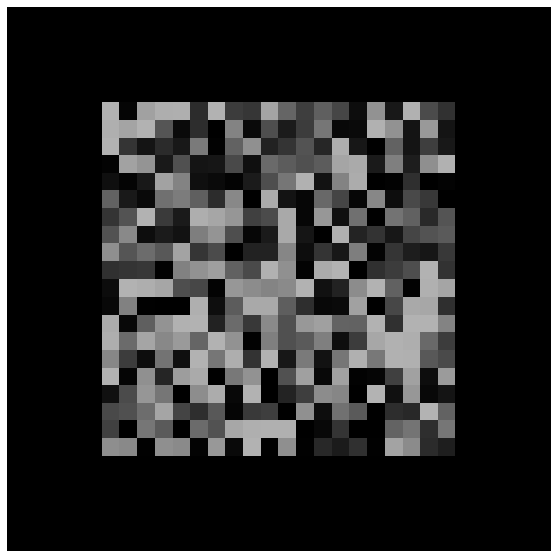

In [32]:
best_mean, best_model = objective_function_and_model(best_chromosome,bas_model, scheme_hcp, voxel_signal)
visualize_result(best_model)

## KROK 2
spróbować dla każdego pixela znajdować optimum oddzielnie, na początek też ESem

In [10]:
def es_for_single_voxel(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, R=None):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 1e10

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    
    def mut3(og):
        S = np.random.uniform(0,sigma, size=(chromosome_length, chromosome_length))
        S = np.dot(S,S.T)
        return og + np.dot(np.random.randn(number_of_offspring, chromosome_length), np.linalg.cholesky(S).T)
    
    def in_domain(chrom, R):
        for p in range(len(chrom)):
            if not R[p][0] < chrom[p] < R[p][1]:
                chrom[p] = np.random.uniform(R[p][0],R[p][1])
        return chrom
    
    def initial_population(population_size, R):
        current_population_solutions = np.zeros((population_size, chromosome_length))
        for pop in range(population_size):
            for p in range(chromosome_length):
                current_population_solutions[pop][p] = np.random.uniform(R[p][0],R[p][1])
        return current_population_solutions
            
    
    mutation_f = mut3

    # generating an initial population
    current_population_solutions = initial_population(population_size, R)

    # evaluating the objective function on the current population
    current_population_objective_values = np.zeros(population_size)
    for i, guy in enumerate(current_population_solutions):
            current_population_objective_values[i] = objective_function(guy)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_solutions = mutation_f(children_population_solutions)
        
        # check if in domain
        for chrom in children_population_solutions:
            chrom = in_domain(chrom, R)                
        
        # evaluating the objective function on the children population
        children_population_objective_values = np.zeros(len(children_population_solutions))
        for i, child in enumerate(children_population_solutions):
            children_population_objective_values[i] = objective_function(child)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])

        I = np.argsort(-current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population_solutions[0]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        
        if log_frequency != -1 and np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 0].min(), log_objective_values[t, 2]))
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions

In [17]:
def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )


def single_voxel_function(chromosome, bas_model, scheme_hcp, voxel_signal):
    '''
    dla danego chromosomu o dl. 6 wypluwa jego MSE
    '''
    model = set_params_from_chrom(chromosome, bas_model, scheme_hcp, voxel_signal)
    return model.mean_squared_error(voxel_signal)

def domain_dict_to_array(d):
    domains_dict = d
    domains_list = np.array(list(domains_dict.values()))
    domains_array = np.array(domains_list[0][0])
    domains_array = np.vstack((domains_array, domains_list[0][1]))
    domains_array = np.vstack((domains_array, domains_list[1]))
    domains_array = np.vstack((domains_array, domains_list[2]))
    domains_array = np.vstack((domains_array, domains_list[3]))
    domains_array = np.vstack((domains_array, domains_list[4]))
    return domains_array


In [ ]:
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
        print(f'Best MSE of voxel x={x},y={y} is {best_value}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)}')

In [20]:
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
        print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')

Best MSE of voxel x=0,y=0 is 0.0076
Best MSE of voxel x=0,y=1 is 0.0138
Best MSE of voxel x=0,y=2 is 0.0141
Best MSE of voxel x=0,y=3 is 0.0089
Best MSE of voxel x=0,y=4 is 0.0061
Best MSE of voxel x=0,y=5 is 0.0045
Best MSE of voxel x=0,y=6 is 0.0081
Best MSE of voxel x=0,y=7 is 0.0067
Best MSE of voxel x=0,y=8 is 0.0068
Best MSE of voxel x=0,y=9 is 0.0039
Best MSE of voxel x=0,y=10 is 0.0074
Best MSE of voxel x=0,y=11 is 0.0069
Best MSE of voxel x=0,y=12 is 0.0032
Best MSE of voxel x=0,y=13 is 0.0035
Best MSE of voxel x=0,y=14 is 0.0043
Best MSE of voxel x=0,y=15 is 0.0018
Best MSE of voxel x=0,y=16 is 0.005
Best MSE of voxel x=0,y=17 is 0.0023
Best MSE of voxel x=0,y=18 is 0.0035
Best MSE of voxel x=0,y=19 is 0.0054
Best MSE of voxel x=1,y=0 is 0.0085
Best MSE of voxel x=1,y=1 is 0.0188
Best MSE of voxel x=1,y=2 is 0.0132
Best MSE of voxel x=1,y=3 is 0.0149
Best MSE of voxel x=1,y=4 is 0.0066
Best MSE of voxel x=1,y=5 is 0.0034
Best MSE of voxel x=1,y=6 is 0.0037
Best MSE of voxel x

In [22]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
#         print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.51s/it]


Final MSE: 0.005457409362199287 and STD: 0.003173078210050289
Wall time: 2min 10s


In [23]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 1.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
#         print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.06s/it]


Final MSE: 0.005406610278128987 and STD: 0.0032249079936449735
Wall time: 2min 1s


100%|██████████| 20/20 [04:17<00:00, 12.90s/it]



Final MSE: 0.0054080640519520605 and STD: 0.0031074752814751858
CPU times: user 4min 3s, sys: 50.7 ms, total: 4min 3s
Wall time: 4min 18s


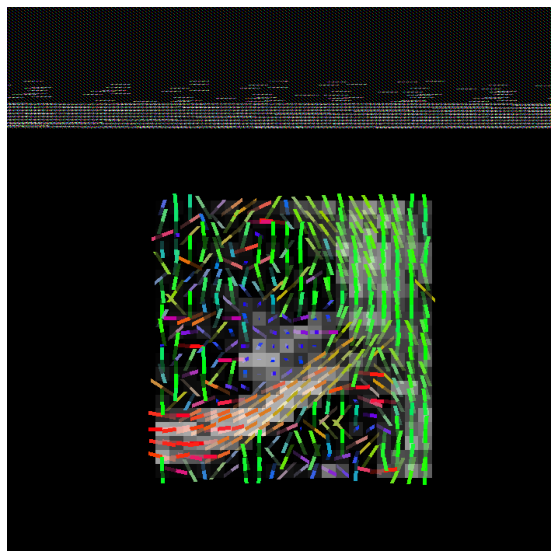

In [18]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 1.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
#         print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:57<00:00,  5.89s/it]



Final MSE: 0.004739696889637226 and STD: 0.0019920936513591002
Wall time: 1min 59s


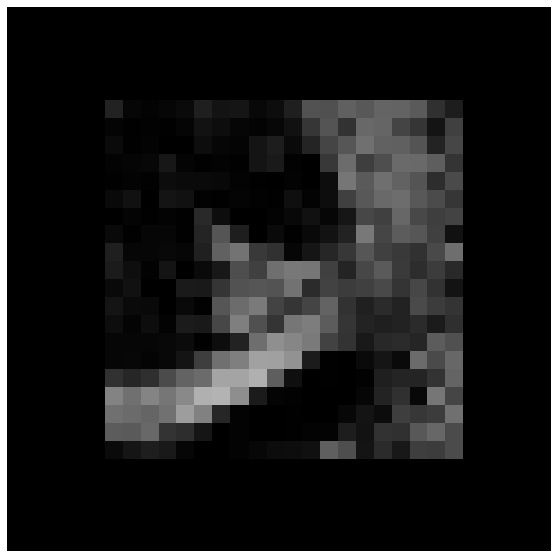

In [27]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 0.2, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
#         print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:54<00:00,  5.74s/it]



Final MSE: 0.005856162053215045 and STD: 0.002455357834323142
Wall time: 1min 56s


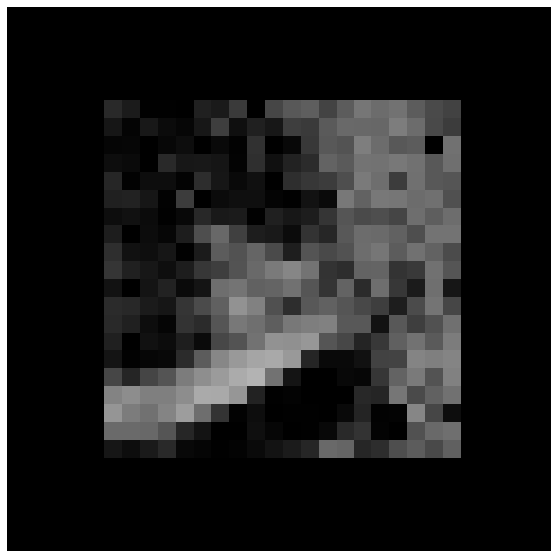

In [28]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 0.01, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [09:35<00:00, 28.78s/it]



Final MSE: 0.004313986666250766 and STD: 0.0017441471598043296
Wall time: 9min 36s


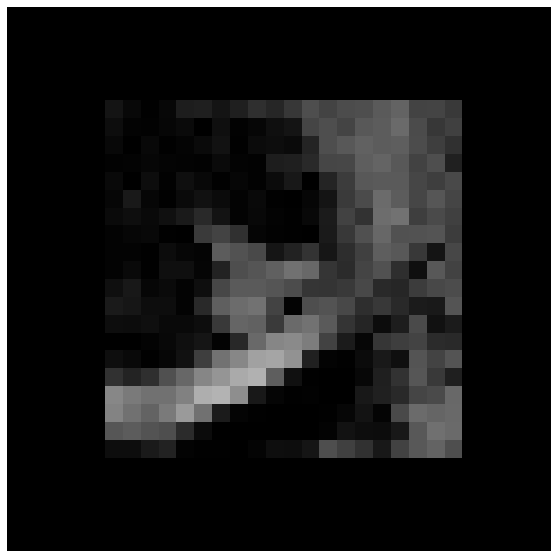

In [29]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 500
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 0.1, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:22<00:00, 16.12s/it]



Final MSE: 0.004668016191103811 and STD: 0.002051872936035473
Wall time: 5min 24s


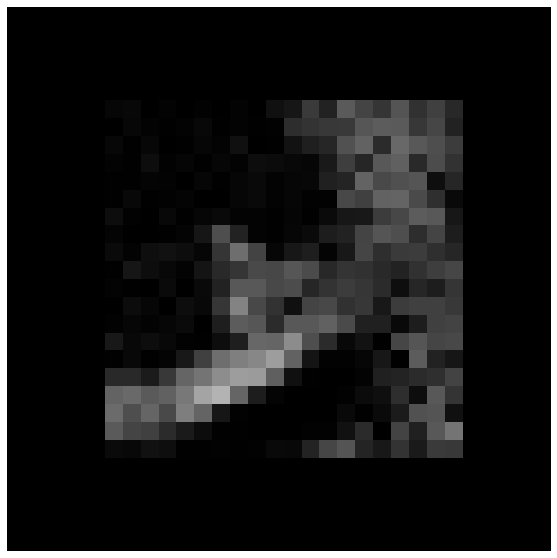

In [31]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 500
T = 5

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 0.2, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)